In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS ,
summarize)

import sklearn.linear_model as skl
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, roc_auc_score, roc_curve

import os

/home/ishanth/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
os.chdir("/home/ishanth/kaggle_churn")
bankdata = pd.read_csv("train.csv")

In [3]:
bankdata

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,165029,15667085,Meng,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0
165030,165030,15665521,Okechukwu,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0
165031,165031,15664752,Hsia,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0
165032,165032,15689614,Hsiung,554,Spain,Female,30.0,7,161533.00,1,0.0,1.0,71173.03,0


In [4]:
bankdata.columns

Index(['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [5]:
bankdata_nums = bankdata.drop(['Surname', 'Geography', 'Gender'], axis=1)

bankdata_nums.corr()

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,1.000000,-0.000387,-0.001201,0.004039,-0.002560,0.000606,-0.000094,-0.004706,0.000418,-0.001552,0.002512
CustomerId,-0.000387,1.000000,0.007364,0.002696,-0.001252,-0.008348,0.004380,-0.005469,-0.002934,0.002891,-0.009947
CreditScore,-0.001201,0.007364,1.000000,-0.008918,0.000942,0.006973,0.011361,-0.002828,0.014790,-0.001820,-0.027383
Age,0.004039,0.002696,-0.008918,1.000000,-0.010830,0.064318,-0.102195,-0.012111,0.003320,-0.005399,0.340768
Tenure,-0.002560,-0.001252,0.000942,-0.010830,1.000000,-0.009481,0.007335,0.005327,-0.005532,0.000971,-0.019565
Balance,0.000606,-0.008348,0.006973,0.064318,-0.009481,1.000000,-0.361033,-0.018584,-0.015073,0.008586,0.129743
NumOfProducts,-0.000094,0.004380,0.011361,-0.102195,0.007335,-0.361033,1.000000,0.005482,0.039736,-0.004285,-0.214554
HasCrCard,-0.004706,-0.005469,-0.002828,-0.012111,0.005327,-0.018584,0.005482,1.000000,-0.021034,0.004438,-0.022141
IsActiveMember,0.000418,-0.002934,0.014790,0.003320,-0.005532,-0.015073,0.039736,-0.021034,1.000000,-0.008080,-0.210237
EstimatedSalary,-0.001552,0.002891,-0.001820,-0.005399,0.000971,0.008586,-0.004285,0.004438,-0.008080,1.000000,0.018827


In [6]:
predictors = list(bankdata.columns.drop(['Surname', 'Geography', 'Gender', 'CustomerId','id','Exited','EstimatedSalary']))

interaction_terms = [('Age', 'Balance')]      

final = predictors + interaction_terms

X = MS(final).fit_transform(bankdata)
Y = bankdata['Exited']

glm = sm.GLM(Y, X, family=sm.families.Binomial())

results = glm.fit()

print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 Exited   No. Observations:               165034
Model:                            GLM   Df Residuals:                   165025
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -68409.
Date:                Sat, 14 Sep 2024   Deviance:                   1.3682e+05
Time:                        20:46:35   Pearson chi2:                 1.82e+05
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1838
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept         -2.9404      0.077    -38.

In [7]:
results.pvalues

intercept         0.000000e+00
CreditScore       1.144049e-19
Age               0.000000e+00
Tenure            1.223663e-11
Balance           1.717913e-11
NumOfProducts     0.000000e+00
HasCrCard         4.638844e-22
IsActiveMember    0.000000e+00
Age:Balance       7.320883e-02
dtype: float64

In [8]:
print(bankdata['Geography'].unique())

bankdata_ohe = pd.get_dummies(bankdata, columns = ['Geography', 'Gender'], dtype = float)
print(bankdata_ohe)

['France' 'Spain' 'Germany']
            id  CustomerId         Surname  CreditScore   Age  Tenure  \
0            0    15674932  Okwudilichukwu          668  33.0       3   
1            1    15749177   Okwudiliolisa          627  33.0       1   
2            2    15694510           Hsueh          678  40.0      10   
3            3    15741417             Kao          581  34.0       2   
4            4    15766172       Chiemenam          716  33.0       5   
...        ...         ...             ...          ...   ...     ...   
165029  165029    15667085            Meng          667  33.0       2   
165030  165030    15665521       Okechukwu          792  35.0       3   
165031  165031    15664752            Hsia          565  31.0       5   
165032  165032    15689614          Hsiung          554  30.0       7   
165033  165033    15732798         Ulyanov          850  31.0       1   

          Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  \
0            0

In [9]:
#Same thing as last logistic reg WIHTOUT USING ISLP LIBRARY


predictors = list(bankdata_ohe.columns.drop(['Surname', 'CustomerId','id','Exited','EstimatedSalary', 'Balance', 'CreditScore', 'Gender_Female']))

#bankdata_ohe['Age_Balance'] = bankdata_ohe['Age'] * bankdata_ohe['Balance']


X = bankdata_ohe[predictors]
Y = bankdata_ohe['Exited']

lasso_logreg = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, random_state=42)  # C controls regularization strength
lasso_logreg.fit(X, Y)

print("Lasso Coefficients:", lasso_logreg.coef_)
print('Lasso intercept:', lasso_logreg.intercept_)

Lasso Coefficients: [[ 0.09405471 -0.01538024 -0.85572588 -0.15613781 -1.28623303 -1.85480477
  -0.85951219 -1.82880486 -0.67154036]]
Lasso intercept: [-1.15403389]


In [10]:
glm = sm.GLM(Y, X, family=sm.families.Binomial())

results = glm.fit()

print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 Exited   No. Observations:               165034
Model:                            GLM   Df Residuals:                   165025
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -65432.
Date:                Sat, 14 Sep 2024   Deviance:                   1.3086e+05
Time:                        20:46:36   Pearson chi2:                 1.85e+05
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2127
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Age                   0.0942      0.00

AUC Score: 0.818


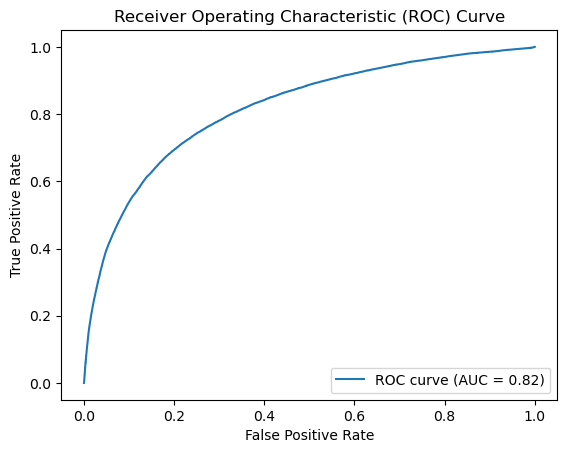

In [11]:
y_prob = lasso_logreg.predict_proba(X)[:, 1] 

auc_score = roc_auc_score(Y, y_prob)
print(f"AUC Score: {auc_score:.3f}")

fpr, tpr, thresholds = roc_curve(Y, y_prob)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [12]:
cv_auc = cross_val_score(lasso_logreg, X, Y, cv=5, scoring='roc_auc')

print(f"Cross-validated AUC: {cv_auc.mean():.3f}")

Cross-validated AUC: 0.817


# Test time

In [13]:
os.chdir("/home/ishanth/kaggle_churn")
bankdata_test = pd.read_csv("test.csv")

bankdata_ohe_test = pd.get_dummies(bankdata_test, columns = ['Geography', 'Gender'], dtype = float)
print(bankdata_ohe_test)


predictors_test = list(bankdata_ohe_test.columns.drop(['Surname', 'CustomerId','id','EstimatedSalary', 'Balance', 'CreditScore', 'Gender_Female']))

X_test = bankdata_ohe_test[predictors_test]

Y_test_pred = lasso_logreg.predict(X_test)
Y_test_prob = lasso_logreg.predict_proba(X_test)[:, 1] 

print(f"Predicted Probabilities: {Y_test_prob}")

            id  CustomerId    Surname  CreditScore   Age  Tenure    Balance  \
0       165034    15773898   Lucchese          586  23.0       2       0.00   
1       165035    15782418       Nott          683  46.0       2       0.00   
2       165036    15807120         K?          656  34.0       7       0.00   
3       165037    15808905  O'Donnell          681  36.0       8       0.00   
4       165038    15607314    Higgins          752  38.0      10  121263.62   
...        ...         ...        ...          ...   ...     ...        ...   
110018  275052    15662091      P'eng          570  29.0       7  116099.82   
110019  275053    15774133        Cox          575  36.0       4  178032.53   
110020  275054    15728456      Ch'iu          712  31.0       2       0.00   
110021  275055    15687541   Yegorova          709  32.0       3       0.00   
110022  275056    15663942       Tuan          621  37.0       7   87848.39   

        NumOfProducts  HasCrCard  IsActiveMember  E

In [14]:
bankdata['id']

0              0
1              1
2              2
3              3
4              4
           ...  
165029    165029
165030    165030
165031    165031
165032    165032
165033    165033
Name: id, Length: 165034, dtype: int64

In [15]:
Y_test_prob

array([0.02035177, 0.56833321, 0.1435356 , ..., 0.06519026, 0.08759778,
       0.34336378])

In [16]:
np.shape(Y_test_prob)

(110023,)

In [17]:
np.shape(bankdata_test)

(110023, 13)

In [18]:
np.shape(bankdata)

(165034, 14)

In [19]:
final_exited = []
for idx, i in enumerate(bankdata_test['id']):
    final_exited.append([i, round(Y_test_prob[idx], 4)])
final_exited_df = pd.DataFrame(final_exited, columns=['id', 'Exited'])

In [22]:
final_exited_df.to_csv('final_exited.csv')